# Bibliotecas
Este notebook utiliza a biblioteca [gymnasium](https://gymnasium.farama.org/api/env/), que fornece uma interface que permite a modelagem do ambiente de uma forma padronizada para avaliação e teste de algoritmos de aprendizado por reforço. Além disso, utilizamos a biblioteca [Stable Baselines3](https://stable-baselines3.readthedocs.io/en/master/guide/quickstart.html) (que inclui a gymnasium), e oferece diversos algoritmos de aprendizado por reforço prontos.

# Tarefa
A tarefa que realizaremos será utilizar um ambiente pronto da biblioteca gymnasium, e implementar o Q-learning para permitir que o agente aprenda adequadamente neste ambiente.




Abaixo, será instalada a biblioteca [Stable Baselines3](https://stable-baselines3.readthedocs.io/en/master/guide/quickstart.html) (que inclui gymnasium).

In [1]:
!pip install "stable-baselines3>=2.0.0a4"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 4.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.9/906.4 MB 3.4 MB/s eta 0:03:38
ERROR: Exception:
Traceback (most recent call last):
  File "/home/pllima0909/Documents/Git/INF01048-Artificial-Inteligence/.venv/lib/python3.12/site-packages/pip/_vendor/urllib3/response.py", line 438, in _error_catcher
    yield
  File "/home/pllima0909/Documents/Git/INF01048-Artificial-Inteligence/.venv/lib/python3.12/site-packages/pip/_vendor/urllib3/response.py", line 561, in read
    data = self._fp_read(amt) if not fp_closed else b""
           ^^^^^^^^^^^^^^^^^^
  File "/home/pllima0909/Documents/Git/INF01048-Artificial-Inteligence/.venv/lib/python3.12/site-packages/pip/_vendor/urllib3/response.py", line 527, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
           ^^^^^^^^^^^^^^^^^^
  File "/home/pllima0909/Documents/Git/INF01048-Artificial-Inteligence/.venv/lib/python3.12/si

#  Formato do ambiente

Um MDP é composto por estados, ações, transição e recompensa. Para modelar um MDP no gymnasium, voce deve definir duas propriedades e os métodos da interface.

### Propriedades

Documentação [aqui](https://gymnasium.farama.org/api/env/).

As propriedades são:
- `observation_space` contém que tipo de espaço gym (gym space: `Discrete`, `Box`, ...) e a forma da observação.
- `action_space` também é um objeto tipo gym space, definindo o tipo de ação que pode ser feita.

O melhor jeito de aprender sobre gym spaces é olhando o [código](https://github.com/Farama-Foundation/Gymnasium/tree/main/gymnasium/spaces). De qualquer forma, os principais tipos são::
- `gym.spaces.Box`: Um espaço (possivelmente sem limites) em $R^n$. Especificamente, Box representa o produto cartesiano de n intervalos fechados. Cada intervalo pode ser do tipo [a, b], (-oo, b], [a, oo), or (-oo, oo). Por exemplo, um vetor 1D ou uma imagem podem ser descritas como Box.

- `gym.spaces.Discrete`: um conjunto discreto $\{ 0, 1, \dots, n-1 \}$, geralmente útil para definir ações.
  Exemplo: se você tem duas ações (esquerda e direita), você pode representar seu espaço de ações com `Discrete(2)`, e ao implementar os métodos do ambiente você faz a ação 0 representar "esquerda" e a 1 representar "direita".


### Métodos

Devem ser implementados 3 métodos obrigatórios e um opcional:

* `reset(seed)` para (re)iniciar o ambiente. Deve retornar a observação/estado inicial para o agente e um dict com informação adicional (pode ser vazio). Recebe uma semente aleatória para usar caso haja aleatoriedade. É chamado sempre que um novo episódio for começar.
* `step(action)` recebe a ação a ser realizada no ambiente. O método deve realizar a ação e retornar uma tupla: `observation, reward, terminated, truncated, info` contendo, respectivamente, a observação (estado atingido), a recompensa recebida, se o episodio terminou por atingir um estado terminal (terminated) ou se foi interrompido (truncado, e.g. limite de tentativas atingido) e um dict com informações adicionais (pode ser vazio).
* `close()`: se precisar "limpar" alguma coisa ao fechar o ambiente
* (opcional) `render(method)`: gera uma visualização do ambiente. A função recebe o método de renderização (string) e deve gerar a visualização apropriada.

Importação das bibliotecas necessárias.

In [3]:
from sklearn.preprocessing import KBinsDiscretizer
import numpy as np
import time, math, random
from typing import Tuple
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
%matplotlib inline

import gymnasium as gym


Criação do ambiente [cart pole](https://www.gymlibrary.dev/environments/classic_control/cart_pole/).

Este ambiente corresponde a uma versão de um problema clássico de controle com aprendizado por reforço. Um pêndulo invertido é preso por uma junta sem atuadores a um carrinho, que se move ao longo de uma pista sem atrito (movimento unidimensional) e sem fatores externos que influenciam o movimento (como vento). O pêndulo invertido é colocado verticalmente no carrinho e o objetivo é equilibrá-lo, aplicando forças no carrinho para a direita ou esquerda.

**Ações**: **aplicar força** para **esquerda** ou **direita** no carrinho, reduzindo ou aumentando a sua velocidade em uma dada direção. Ou seja, uma ação $a \in \{0, 1\}$. A velocidade que é reduzida ou aumentada pela força aplicada não é fixa e depende do ângulo para o qual o pêndulo aponta. O centro de gravidade do pêndulo impacta na quantidade de energia necessária para mover o carrinho abaixo dele.

**Observações que caracterizam cada estado:** é um ndarray com formato (4,) com os valores correspondentes às seguintes posições e velocidades:

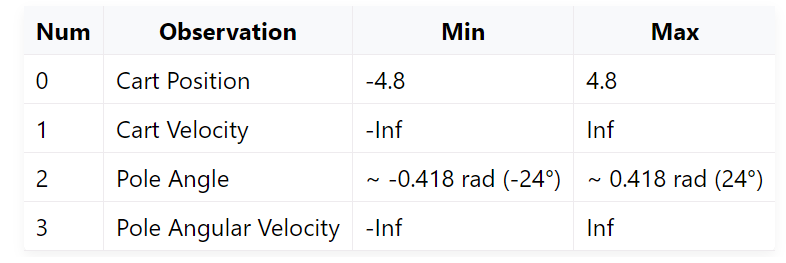

Embora os intervalos acima indiquem os valores possíveis para o espaço de observação de cada elemento, eles não refletem os valores permitidos do espaço de estados em um episódio não terminado. Particularmente:

*   A posição x do carrinho (índice 0) pode assumir valores entre (-4,8, 4,8), mas o episódio termina se o carrinho sair do intervalo (-2,4, 2,4).
*   O ângulo do pêndulo pode ser observado entre (-0,418, 0,418) radianos (ou ±24°), mas o episódio termina se o ângulo do pêndulo não estiver na faixa (-0,2095, 0,2095) (ou ±12°).

**Recompensa:** Como o objetivo é manter o pêndulo em pé pelo maior tempo possível, é atribuída uma recompensa de +1 para cada passo dado, incluindo o passo de terminação.

**Estado inicial:** Todas as observações recebem um valor uniformemente aleatório em (-0,05, 0,05)

**Fim do episódio:** O episódio termina se ocorrer alguma das seguintes situações:
Terminação: O ângulo do pêndulo é menor que ±12°.
Terminação: A posição do carrinho é menor/maior que ±2,4 (o centro do carrinho atinge a borda da tela).
Truncamento: a duração do episódio é maior que 500

O ambiente é, por padrão, **determinístico**. Embora seja possível simular a adição de ruído estocástico às ações.

In [4]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
#render_mode="rgb_array" é para permitir que o ambiente gere uma representação em imagem de cada iteração

# Box(4,) significa que é um array com 4 posições (cada qual uma característica do ambiente)
print("Espaço de observação:", env.observation_space)
# Discrete(2) significa que existem duas ações discretas
print("Espaço de ações:", env.action_space)

Espaço de observação: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Espaço de ações: Discrete(2)


Método reset e realização de uma ação em um dado estado.

In [6]:
# O método reset é executado no início de cada episódio, para reiniciar o ambiente
obs = env.reset()
# Amostra uma ação aleatória do espaço de ações possíveis do ambiente (neste caso, esquerda ou direita)
action = env.action_space.sample()
print("Ação aleatória:", action)
#Simula a realização da ação no ambiente
obs, reward, truncated, terminated, info = env.step(action)
# obs é um numpy array
# info é um dicionário vazio, mas pode conter informações de debug em alguns ambientes
# reward é um escalar que representa a recompensa
print(obs, reward, truncated, terminated, info)

Ação aleatória: 1
[-1.3497102e-04  1.9405410e-01  1.3205357e-02 -2.5637785e-01] 1.0 False False {}


O ambiente cart pole tem um espaço de estados contínuo.
Para aplicar o Q-learning, vamos discretizar o espaço.
Vamos adotar como representação do estado apenas o **ângulo** e a **velocidade agular** do pêndulo invertido.

In [7]:
# Esta linha define a variável n_bins como uma tupla com dois valores
#(6,12) indica que vamos discretizar o ângulo em 6 valores e a velocidade angular em 12 valores, resultando em 72 estados possíveis. Cada estado representa uma faixa de ângulos e velocidades
n_bins = ( 6 , 12 )

#Define os limites inferiores e superiores de cada variável
lower_bounds = [ env.observation_space.low[2], -math.radians(50) ]
upper_bounds = [ env.observation_space.high[2], math.radians(50) ]

#Função que converte/mapeia os valores contínuos em uma tupla com dois valores discretos que representam um estado. Por exemplo (0,0) é o estado representado pela primeira faixa de ângulos e velocidades
# Os nomes _ e __ são frequentemente usados como nomes de variáveis quando você não precisa realmente dos valores dos parâmetros, mas precisa mantê-los lá por razões de sintaxe.
#Pode ser modificado para considerar outras variáveis como parte do estado a ser discretizado
def discretizer( _ , __ , angle, pole_velocity ) -> Tuple[int,...]: #Função com anotação de tipo
    est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    est.fit([lower_bounds, upper_bounds ])
    return tuple(map(int,est.transform([[angle, pole_velocity]])[0]))

Inicialização da tabela Q com zero, para todos os pares estado ação possíveis.
A tabela Q tem tamanho 6 X 12 X 2.

In [8]:
#n_bins + (env.action_space.n,) cria uma tupla que combina o número de bins para as variáveis de estado com o número de ações possíveis.
#Isso resulta em uma tupla (6, 12, 2)
Q_table = np.zeros(n_bins + (env.action_space.n,))

Define uma função **política**, que mapeia um estado em um valor inteiro, que representa o índice da melhor ação (que tem o maior valor Q) para o estado.

In [9]:
def policy( state : tuple ):
    #Q_table[state] retorna uma lista com os valores Q para aquele estado (um para cada ação), representado por uma tupla.
    #np.argmax(Q_table[state]) retorna o índice da ação com maior valor Q da lista de valores Q para aquele estado
    return np.argmax(Q_table[state])

A função a seguir calcula parte da regra de atualização do Q-learning, focando apenas na parte que envolve a experiência que o agente acaba de vivenciar.

Ela recebe como parâmetros a recompensa recebida por realizar a ação a no estado s, o novo estado alcançado ao realizar esta ação, e o fator de desconto (gama). A função retorna o valor que representa a experiência que ele acaba de vivenciar.

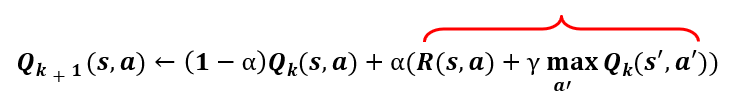

In [10]:
def experience_learned( reward : float ,  new_state : tuple , discount_factor=1 ) -> float:
    future_optimal_value = np.max(Q_table[new_state])#Obtém o valor Q máximo associado ao estado new_state (ou seja, da ação com maior valor Q).
    learned_value = reward + discount_factor * future_optimal_value
    return learned_value

A função a seguir calcula a taxa de aprendiagem adequada em cada episódio. A função que faz a taxa de aprendizagem decair ao longo das iterações.

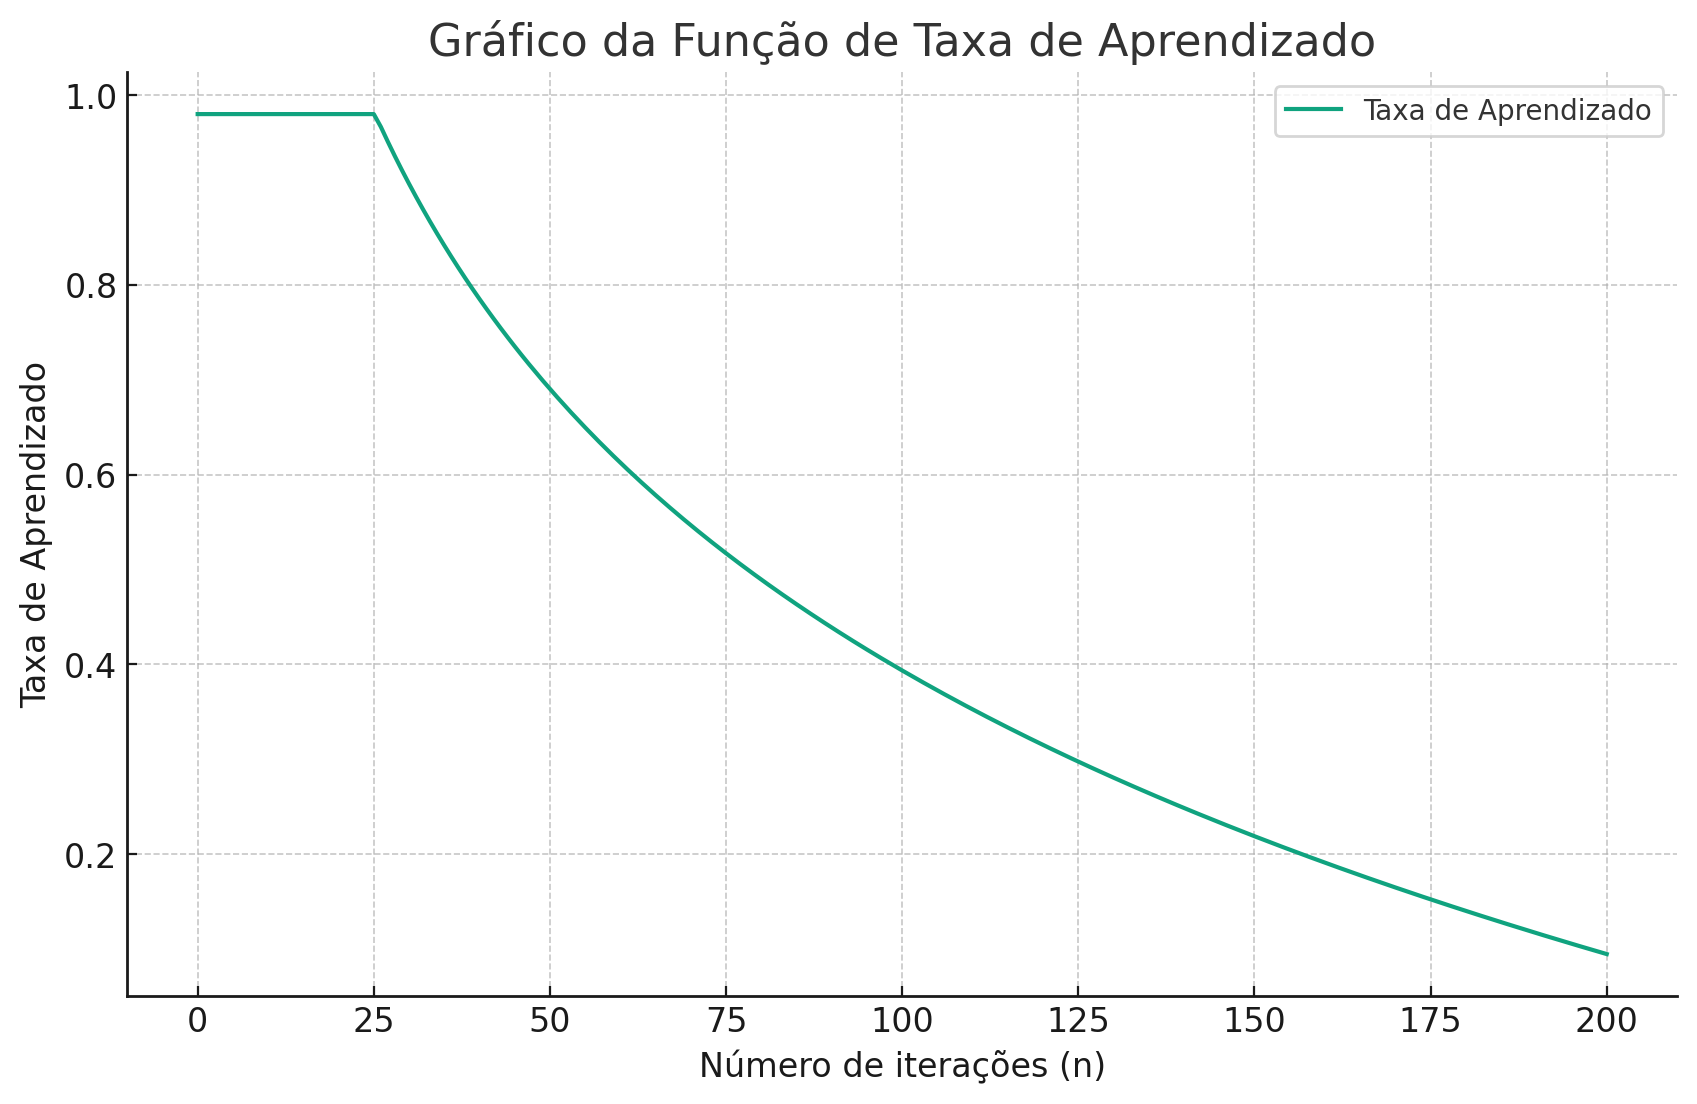

In [11]:
#Taxa de aprendizagem decrescente
def learning_rate(n : int , min_rate=0.01 ) -> float  :
    return max(min_rate, min(0.99, 1.0 - math.log10((n + 1) / 25)))


A seguir, algumas outras possibilidades comuns para realizar o decaimento da taxa de aprendizagem:

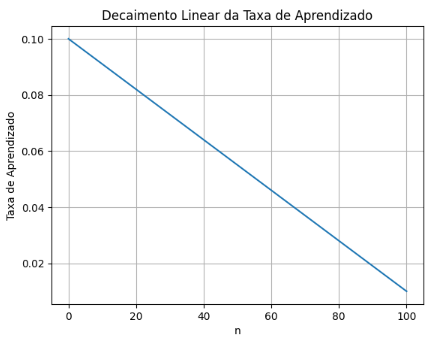

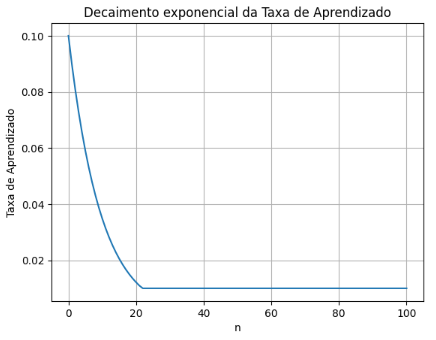

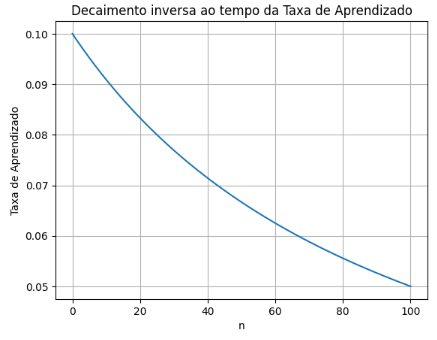

In [12]:
#Decaimento linear de taxa de aprendizagem
def linear_decay_learning_rate(e, initial_rate=0.1, final_rate=0.01, max_episodes=1000):
    return initial_rate - (e / max_episodes) * (initial_rate - final_rate)

def exponential_decay_learning_rate(e, initial_rate=0.1, decay_rate=0.9, min_rate=0.01):
    return max(min_rate,initial_rate * (decay_rate ** e))

def inverse_time_decay_learning_rate(e, initial_rate=0.1, decay_rate=0.01, min_rate=0.01):
    return max(min_rate,initial_rate / (1 + decay_rate * e))

A função a seguir calcula a taxa de exploração (épsilon) adequada para cada episódio de treinamento.
A Função que faz a taxa de exploração (épsilon) decair no tempo, seguindo um comportamento análogo ao comportamento da função que decai a taxa de aprendizagem.

**Nota**: Não é necessário que a taxa de aprendizagem e a taxa de exploração decaiam da mesma forma.

In [13]:
#Taxa de exploração (épsilon)
def exploration_rate(n : int, min_rate= 0.1 ) -> float :
    return max(min_rate, min(0.99, 1.0 - math.log10((n  + 1) / 25)))

Laço de treinamento do agente utilizando Q-learning.

* **n_episodes**: define o número de episódios de treinamento
* **n_steps**: define o número máximo de iterações em cada episódio
* **discount_factor**: define o valor (em [0,1]) do fator de desconto (gama)

# Algumas configurações possíveis

Configuração 1:
* n_episodes: 1000 episódios
* n_steps: 500 (coincide com o número de passos de truncamento)
* discount_factor: 0.98 (agente não valoriza maximalmente o futuro)

Configuração 2:
* n_episodes: 500 episódios
* n_steps: 50 (terminando antes do limite de truncamento)
* discount_factor: 1 (agente eternamente paciente em relação a recompensas futuras)

In [14]:
#Training
n_episodes = 1000
n_steps = 500
discount_factor = 0.99
for e in range(n_episodes):
    if e%(100)==0:
        print(f"Episódio de treinamento: {e}")

    #Reseta o estado
    #Discretiza o estado
    #O operador * desempacota a tupla em valores individuais
    current_state, done = discretizer(*env.reset()[0]), False

    #Inicializa o número de passos em zero
    steps = 0

    #Enquanto o episódio não terminar e o número de passos for menor que o máximo
    while done==False and steps< n_steps:
        action = 0

        #Com probabilidade e (épsilon), seleciona uma ação aleatória
        if np.random.random() < exploration_rate(e) :
            action = env.action_space.sample() # explore
        else:
            #Determina a melhor ação de acordo com a política
            action = policy(current_state) # exploit

        #Realiza a ação, obtém o novo estado e o discretiza
        obs, reward, done, truncated, info = env.step(action)
        new_state = discretizer(*obs)

        #Atualiza a taxa de aprendizagem no tempo
        lr = learning_rate(e)
        #Determina o valor associado à experiência vivenciada na última iteração
        learnt_value = experience_learned(reward , new_state, discount_factor)
        #Determina o valor associado atualmente à realizar essa ação neste estado
        old_value = Q_table[current_state][action]
        #Atualiza, conforme a regra de atualização do Q-learning
        Q_table[current_state][action] = (1-lr)*old_value + lr*learnt_value

        #estado atual é o novo estado
        current_state = new_state

        steps = steps+1

Episódio de treinamento: 0
Episódio de treinamento: 100
Episódio de treinamento: 200
Episódio de treinamento: 300
Episódio de treinamento: 400
Episódio de treinamento: 500
Episódio de treinamento: 600
Episódio de treinamento: 700
Episódio de treinamento: 800
Episódio de treinamento: 900


Testa o agente, com o conhecimento aprendido durante o treinamento no próprio ambiente em que ele foi treinado.

* **max_n_steps** indica o número máximo de passos de execução da interação com ambiente.
* **num_selected_frames**: indica o número total de frames utilizados para a animação. Dependendo do número de passos efetivamente realizados, utilizar todos os frames pode fazer com que a geração da animação demore.

In [20]:
# Executar o ambiente com a política aprendida

#Define o número máximo de passos de execução da interação com ambiente
max_n_steps = 2000
#Define o número de frames de toda animação com total de steps frames
num_selected_frames = 40

#Reinicia o ambiente
current_state, done = discretizer(*env.reset()[0]), False
frames = []#lista para armazenar as imagens de cada iteração
steps = 0
while (not done) and steps<max_n_steps:
    action = policy(current_state)
    obs, reward, done, truncated, info = env.step(action)
    new_state = discretizer(*obs)
    current_state = new_state
    steps = steps+1
    #Cria um frame que representa a situação atual
    frames.append(env.render())

# Fechar o ambiente após a execução
env.close()

print(f"O número total de passos executado foi: {steps}")

#-----------------------
#A parte seguinte é para ajustar a animação e não é essencial
#-----------------------

#Se o número máximo de frames for maior que o de passos realizados, ajusta o número de frames com o número de passos
if num_selected_frames > steps:
   num_selected_frames = steps

# Função para inicializar a animação
def init():
    ax.clear()
    return ax,


# Função para atualizar o quadro da animação
def animate(i, frames, num_selected_frames, steps):
    ax.clear()
    ax.imshow(frames[i])
    step = int(i * (steps / float(num_selected_frames)))  # Calcula o número de passos de interação do agente em função do índice do frame
    ax.text(10, 10, f'Passo de Inter. {step + 1}', color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
    return ax,

# Configurar a figura e o eixo para a animação
plt.ioff()
fig, ax = plt.subplots()
plt.ion()

num_frames = len(frames)

# Calcule os índices dos frames uniformemente espaçados
selected_frame_indices = np.linspace(0, num_frames-1, num_selected_frames, dtype=int)
selected_frame_indices = np.append(selected_frame_indices,num_frames-1)

# Selecione os frames correspondentes aos índices calculados
selected_frames = [frames[i] for i in selected_frame_indices]

# Criar a animação usando FuncAnimation
#ani = FuncAnimation(fig, animate, fargs=(selected_frames,), init_func=init, frames=num_selected_frames, repeat=False)
ani = FuncAnimation(fig, animate, fargs=(selected_frames, num_selected_frames, steps), init_func=init, frames=num_selected_frames, repeat=False)

# Exibir a animação no Jupyter Notebook
HTML(ani.to_jshtml())

O número total de passos executado foi: 18


Teste variações das configurações:

* Utilizar outras variáveis do estado
* Diferentes formas de discretizar (em mais estados)
* Diferentes formas de ajustar as taxas de aprendizagem e exploração (inclusive mantendo fixas)
* Diferentes quantidades de episódios e iterações por episódio
* Diferentes valores para o fator de desconto
* ...